# Ein nayves neuronales Netz

**Von Yves Oehlschläger**


![Nicht machmachen](img/neonbrand--Cmz06-0btw-unsplash.jpg)

[Photo by NeONBRAND on Unsplash](https://unsplash.com/photos/-Cmz06-0btw)


## Don't try this at home 💀

* Die Zeit ist begrenzt, daher vereinfache ich Dinge, versuche dabei aber -so gut es geht- korrekt zu bleiben.
* Kein production-ready Code
* Kein Feature Engineering
* Kein Validation Set
* This ain't no fancy, jaw dropping Tensorflow demo

**Ziel ist es, neuronale Netze prinzipiell zu verstehen. Was ist ein neuronlaes Netz? Wie funktioniert es? Was können wir nicht mehr verstehen?**


In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

np.random.seed(1337)

# Was ist ein neuronales Netz? 🤔

![Ein neuronales Netz](img/Net.png)


* Neuronale Netze zählen zum **Supervised Learning**.
  * Trainingsdaten mit Labeln.
* Ein neuronales Netz besteht aus **Layer**n/Schichten.
  * Der Inputlayer sind die Eingangswerte/-vektoren.
  * Beliebig viele Hidden Layer.
  * Ein Outputlayer.
* Ein Layer besteht aus **Neuron**en.
* Ein Neuron brechnet einen Outputwert, die Activation/Aktivierung, aus den Inputwerten.
* Die Outputwerte aller Neuronen eines Layers sind die Inputwerte für den nächsten Layer.
* Wiederhole bis der Outputlayer, erreicht ist.
  * Outputlayer besteht aus einem einzelnen Neuron:
    * Regression
    * Output ist der prognostizierte Wert.
  * Outputlayer besteht aus mehreren Neuronen:
    * Klassifizierung
    * Ein Neron pro Klasse.
    * Neuron mit höchster Aktivierung gewinnt.
* Diesen Vorgang nennt man **Feedforward**.
* Trainiert wird mittels **Backpropagation**.

## Veranschaulichung 💡

In einem neuronalen Netz zur Ereknnung von Buchstaben/Ziffern in einem Bild:

* Die Neuronen des ersten Hidden Layers *könnten* auf Kanten in Regionen des Bildes reagieren.
* Die Neuronen des zweiten Hidden Layers *könnten* aus diesen Kanten einfache Formen, bspw. Kreise oder längere Linien erkennen.
* Die Neuronen des Outputlayers *könnten* aus diesen Formen Buchstaben/Ziffern erkennen.

Würde dies in einem neuronalen Netz tatsächlich so passieren? Sehr, sehr, sehr, sehr höchstwahrscheinlich nicht, aber die Vorstellung hilft.

# Was ist ein Neuron? 🤔

![Neuron](img/neuron.png)

* Ein Neuron hat 1 bis n Inputwerte: $x =  \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_n\end{pmatrix}$
* Zu jedem Inputwert gibt es ein Gewicht: $w =  \begin{pmatrix} w_1 \\ w_2 \\ \vdots \\ w_n\end{pmatrix}$
  * Für das einzelne Neuron sind die unterschiedlichen Inputwerte unterschiedlich wichtig.
* Ein Neuron hat einen Bias: $b$
  * In mancher Literatur auch das "Nullte Gewicht" zu einem konstanten Input $x_0 = 1$.
  * "Lautstärke" des Neuron
* Ein Neuron hat eine Aktivierungsfunktion: $f$
  * Normiert die Outputwerte.

## Veranschaulichung 💡

Stellt euch vor, ihr steht vor einem Autokauf, ihr habt die Daten von verschiedenen, zur Wahl stehenden Autos und fragt im Bekanntenkreis um Rat. Ihr seid dann der Outputlayer, jede gefragte Person ist ein Neuron im Hidden Layer. Jede Person wird die einzelnen Features anders bewerten, einer Person ist Leistung sehr wichtig, einer anderen ein sparsamer Verbrauch, jede Person hat also unterschiedliche Gewichte für die Features.

Jede Person wird auch ihre Meinung unterschiedlich offensiv vertreten, das ist jeweils der Bias. Ihr selbst kennt aber eure Bekannten und gewichtet ihre Meinungen dann noch mal für euch selbst (A ist ein Schwätzer, B ist sehr introvertiert, aber sagt meist vernünftige Sachen, etc), daher setzt sich nicht automatisch die lauteste Person durch.

## Wie berechnet sich die Aktivierung? 🤔

Die Aktivierung ist der Wert von $f$ angewendet auf die Summe aus $b$ und dem Skalarprodukt von $x$ und $w$.

$$activation = f(b + x \cdot w) = f(b + \sum_{i=1}^{n} (x_i * w_i))$$

Das klingt schlimmer, als es tatsächlich ist:

```csharp
var scalarProduct = 0;
for(var i = 1; i <= n; i++)
{
  scalarProduct += w[i] * x[i];
}
return f(b + scalarProduct)
```

## Welche Aktivierungsfunktionen gibt es? 🤔

<IPython.core.display.Javascript object>


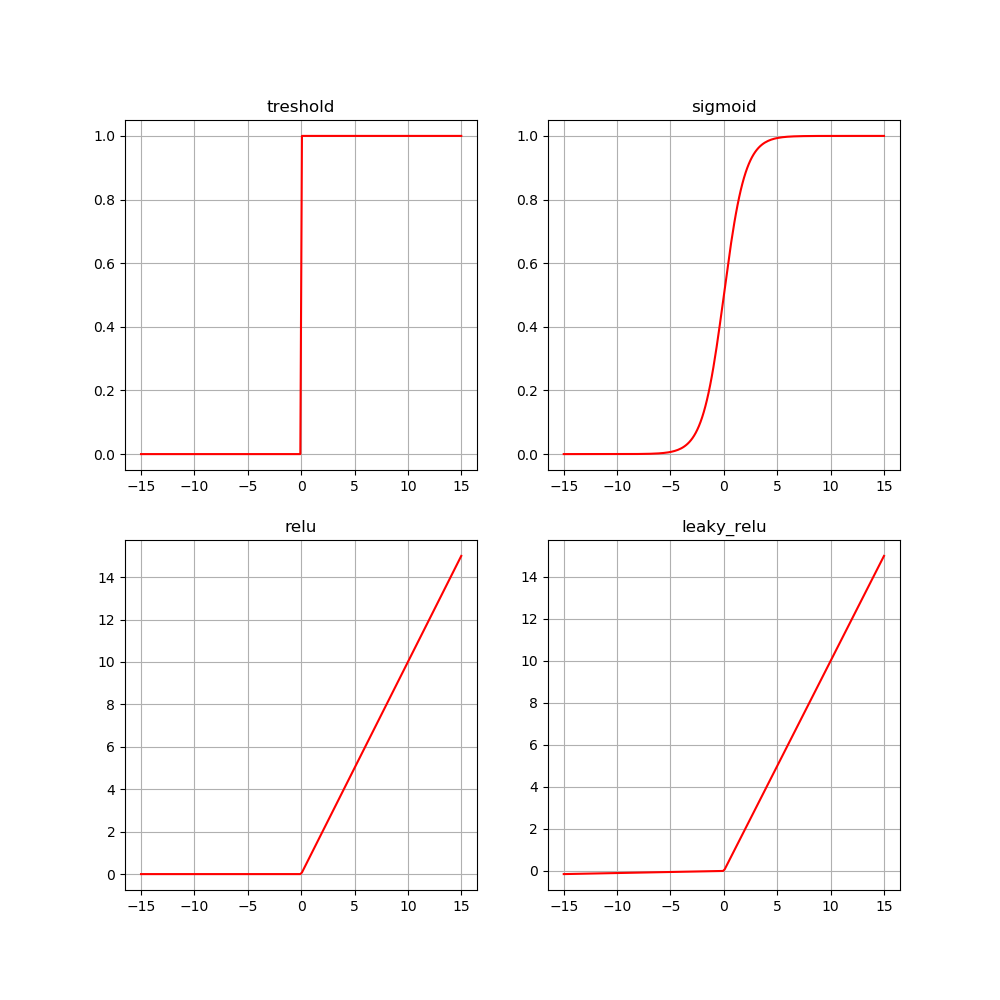

In [2]:
def treshold(x):
    """Unbarmherzig in Schwellenwertnähe"""
    return np.where(x>0, 1, 0)

def sigmoid(x):
    """Keine Schwellenwertproblematik, ist aber relativ komplex/rechenintensiv"""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """rectified linear unit
    Sehr einfach, aber auch mit Informationsverlust bei 0"""
    # return np.maximum(0, x)
    return np.where(x>0, x, 0)

def leaky_relu(x):
    """Federt die Schwellenwertproblematik von ReLU ab"""
    return np.where(x>0, x, .01*x)

x = np.linspace(-15, 15, 200)

fig = plt.figure(figsize=(10, 10))

for i, function in enumerate([treshold, sigmoid, relu, leaky_relu]):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x, function(x), "r")
    ax.set_title(function.__name__)
    ax.grid(True)
  
fig.show()

# Unser kleines Netz 😊

Wir erstellen ein Neuronales Netz ohne externe Bibliotheken (außer Numpy für Vektorrechnung).

Die Art des Netzes richtet sich immer nach den vorhandenen Daten, deshalb:

## Daten, wir brauchen Daten!

* Die Testdaten sind komplett ausgedacht und höchstwahrscheinlich unrealistisch.
* Das ist nicht schlimm, da neuronale Netze sich auf Datensätze *trainieren* lassen, sie haben und benötigen *kein Wissen/Verständnis* über die Daten.
* Wir wollen wissen, ob eine Stadt als sicher (1) oder unsicher (0) gilt.
* Wir nutzen hierzu ein neuronales Netz mit einem Hidden Layer aus zwei Neuronen und einem einem einzelnen Neuron im Outputlayer. In diesem Fall können wir die Sigmoid Funktion als Aktivierung für alle Neuronen nutzen.
* Als Input dienen die zwei Parameter:
  * Anzahl Polizeireviere
  * Durchschnittliche Anzahl Morde pro Woche

In [3]:
X = np.array([
    [10., 0.],
    [8, 0],
    [5, 10],
    [2, 10],
    [8, 1],
    [5, 5]
])

y = np.array([
    1,
    1,
    0,
    0,
    1,
    0
])

X, y

(array([[10.,  0.],
        [ 8.,  0.],
        [ 5., 10.],
        [ 2., 10.],
        [ 8.,  1.],
        [ 5.,  5.]]), array([1, 1, 0, 0, 1, 0]))

<IPython.core.display.Javascript object>


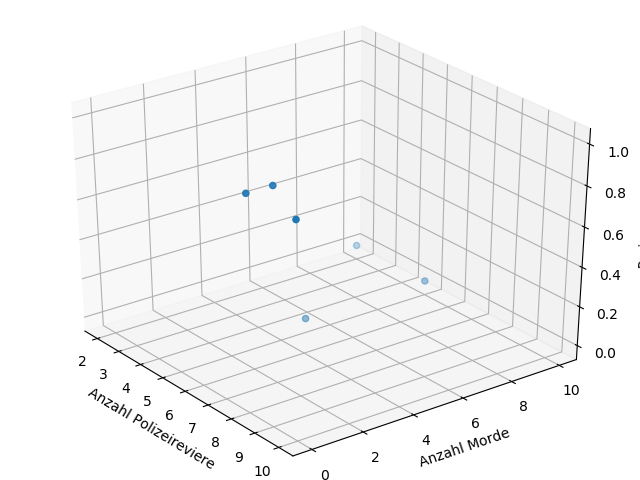

In [4]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], y)

ax.set_xlabel("Anzahl Polizeireviere")
ax.set_ylabel('Anzahl Morde')
ax.set_zlabel('Preis')

fig.show()

## Wir coden ein Neuron 

In [5]:
class Neuron():
    def __init__(self, number_of_inputs=2, activation_function=sigmoid):
        self.bias = np.random.randn()
        self.weights = np.random.uniform(low=-1, high=1, size=(number_of_inputs,)).flatten()
        self.activation_function = activation_function

    def __str__(self):
        return f"Bias: {self.bias}; Weights: {self.weights};\n"

    def activation(self, input_values):
        return self.activation_function(np.dot(input_values, self.weights) + self.bias)


for i in range(5):
    print(f"Sample #{i+1}, {i%3 + 1} inputs:")
    print(Neuron(i%3 + 1))

Sample #1, 1 inputs:
Bias: -0.7031873098624105; Weights: [-0.44374696];

Sample #2, 2 inputs:
Bias: -0.49028236278771464; Weights: [-0.08136623 -0.35799892];

Sample #3, 3 inputs:
Bias: -1.7143346483924986; Weights: [ 0.95217057  0.46562911 -0.76945155];

Sample #4, 1 inputs:
Bias: 0.13245331904914132; Weights: [-0.22744986];

Sample #5, 2 inputs:
Bias: -0.911897938600617; Weights: [ 0.96709721 -0.11355026];



## Wir coden einen Layer

Nein, machen wir nicht. 

Wir könnten, aber ich hardcode die Neuronen direkt in das Netz, dadurch wird das Training später nachvollziehbarer.

## Wir coden ein Neuronales Netz


In [6]:
class NayvesNeuronalNetwork():
    def __init__(self):
        self.hidden_1 = Neuron()
        self.hidden_2 = Neuron()
        self.output = Neuron()

    def __str__(self):
        return "Nayves Neuronal Network:\n\n" + \
        f"First Neuron in Hidden Layer:\n{self.hidden_1}\n" + \
        f"Second Neuron in Hidden Layer:\n{self.hidden_2}\n" + \
        f"Single Neuron in Output Layer:\n{self.output}"

    def feedforward(self, x):
        hidden_output = np.array([
            self.hidden_1.activation(x),
            self.hidden_2.activation(x)
        ])
        return self.output.activation(hidden_output)

nnn = NayvesNeuronalNetwork()
print(nnn)

Nayves Neuronal Network:

First Neuron in Hidden Layer:
Bias: 0.3125281715780318; Weights: [0.57911668 0.58823715];

Second Neuron in Hidden Layer:
Bias: -1.0982689131528467; Weights: [0.16851626 0.52034355];

Single Neuron in Output Layer:
Bias: -1.8162009192623523; Weights: [-0.62438319 -0.4236657 ];



# Ein erster Durchlauf


In [7]:
for x_test, y_test in zip(X, y):
    print(f"Feautures: {x_test}, Label: {y_test}")
    o = nnn.feedforward(x_test)
    diff = abs(o - y_test)
    print(f"NNN Output: {o:0.3}")
    print(f"Differenz: {diff:0.3}")
    print("\t Sehr daneben\n" if diff > .5 else "\tNaja, naja...\n" if diff > 0.2 else "")

Feautures: [10.  0.], Label: 1
NNN Output: 0.0623
Differenz: 0.938
	 Sehr daneben

Feautures: [8. 0.], Label: 1
NNN Output: 0.0645
Differenz: 0.935
	 Sehr daneben

Feautures: [ 5. 10.], Label: 0
NNN Output: 0.0541
Differenz: 0.0541

Feautures: [ 2. 10.], Label: 0
NNN Output: 0.0542
Differenz: 0.0542

Feautures: [8. 1.], Label: 1
NNN Output: 0.0614
Differenz: 0.939
	 Sehr daneben

Feautures: [5. 5.], Label: 0
NNN Output: 0.0559
Differenz: 0.0559



Gar nicht mal so gut... 😂

# Training eines neuronalen Netzwerks

## Wie "gut" ist unser Netzwerk? 🤔

Um die Güte zu bestimmen, führen wir eine Verlustfunktion/**Loss Function** ein. Eine typische Wahl hierfür ist **Mean Squared Error**.

$$ MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - o_i)^2 $$

Bzw. die Variation:

$$ \frac{1}{2}MSE = \frac{1}{2*n} \sum_{i=1}^{n}(y_i - o_i)^2 $$

Bonuspunkte für einen Verdacht warum. 🤓

Vorteile von Mean Squared Error:

* Durch das Quadrat ist das Ergebnis immer positiv. Abweichungen in positiver und negativer Richtung können sich nicht aufheben.
* Durch das Quadrat werden hohe Abweichungen "härter" bestraft, kleine Abweichungen unter Eins werden sogar belohnt.


In [8]:
def mean_squared_error(y, o):
    return ((y - o) ** 2).mean()

In [9]:
o = np.apply_along_axis(nnn.feedforward, 1, X)

mean_squared_error(y, o)

0.4407465500172101

## Wie wird unser Netzwerk besser? 🤔

* Wir haben eine Metrik zur Güte des Netzwerks.
* Diese Metrik soll möglichst gering sein.
* Die Metrik ist eine Funktion.
* Eine Funktion soll möglichst gering sein.
* Gab es da nicht etwas, ich glaube das hieß "Extremwerte" und hatte was mit einer "Ableitung" zu tun...

<IPython.core.display.Javascript object>


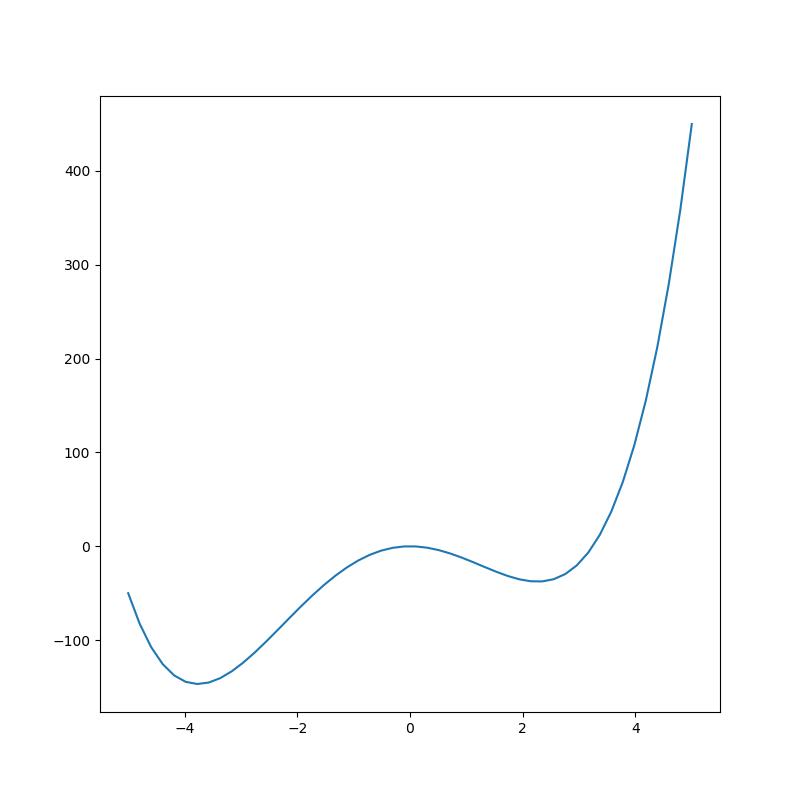

In [10]:
xs = np.linspace(-5, 5)
def f(x) :
    return x**4 + 2 * x**3 - 17 * x**2
plt.figure(figsize=(8,8))
plt.plot(
    xs,
    f(xs)
)
plt.show()

Im obigen Beispiel liese sich das Minimum relativ einfach bestimmen, allerdings ist die Funktion $f$ auch nur von einem einzelnen Parameter $x$ abhängig.

Die Parameter der Loss Function sind alle Gewichte und Biase, in unserem einfachen Beipsiel wären das bereits neun Parameter. Somit ist der Ansatz $f'(x)=0$ nicht praktikabel, es wird ein Minimum für 

$$L(w_{1h1}, w_{2h1}, b_{h1}, w_{1h2}, w_{2h2}, b_{h2}, w_{1o}, w_{2o}, b_{o})$$

benötigt. Das verkompliziert die Sache ein wenig. 😂


## Gradient

Der Gradient ist ein Vektor, welche die Richtung der größten Veränderung (Steigung) angibt.

$$\nabla f = \begin{pmatrix} \frac{\partial f}{\partial x_1} \\ \vdots \\ \frac{\partial f}{\partial x_n}\end{pmatrix}$$


## Gradient Descent/Gradientenverfahren

Gradient Descent ist ein Algorithmus zum schrittweisen Finden eines Minimumns einer Funktion $f$. Beginnend mit einem beliebigen "Startpunkt" $a_0$ gilt:

$$a_{i+1} = a_i - \gamma * \nabla f $$

In jedem Schritt wird also entgegen der höchsten Steigung (mulitpliziert mit einem Faktor $\gamma$) gegangen.


### Ein einfaches Beispiel

Für eine handelsübliche Parabel entspricht der Gradient der Steigung im Punkt. Wir betrachten die Parabel $y = x^2 - 5x + 2$, das Minimum liegt bei $x=2,5$, wir starten diese Suche bei $x=4$.


<IPython.core.display.Javascript object>


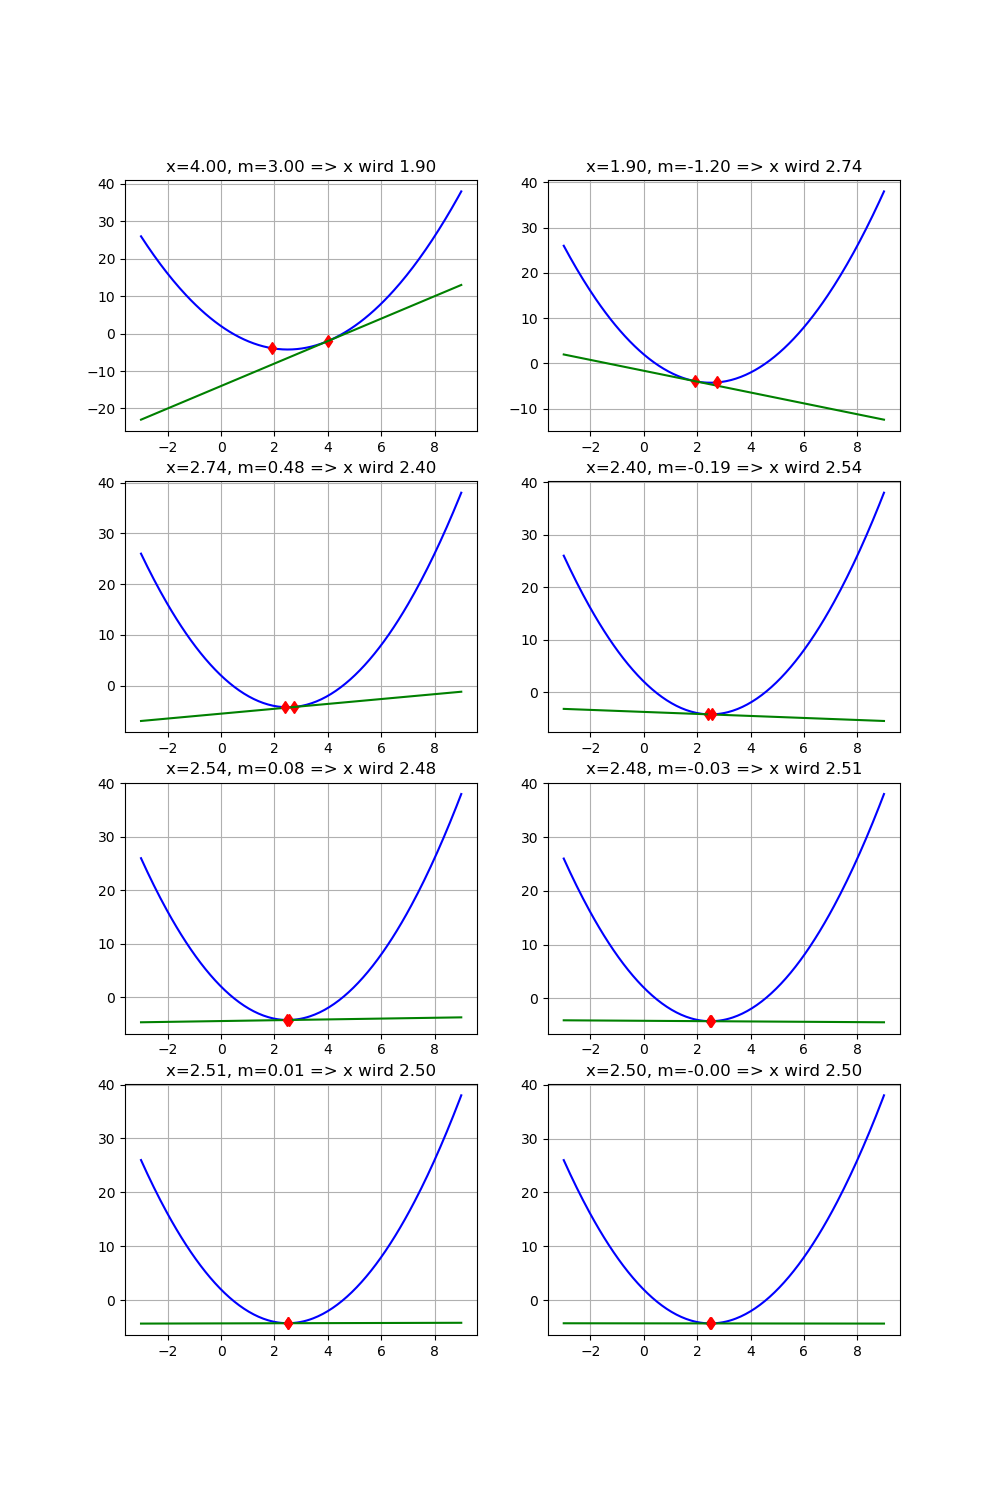

In [11]:
def example(xs):
    return xs**2 - 5*xs + 2

def example_derivative(xs):
    return 2*xs - 5

def tangent(xs, x=x):
    return example(x) + example_derivative(x) * (xs - x)

xs = np.linspace(-3, 9, 200)
x = 4
rate = 0.7
#rate = 0.001 # Langam
#rate = 5 # Overshoot

fig = plt.figure(figsize=(10, 15))

for i in range(8):
    ax = fig.add_subplot(4,2,i+1)
    ax.plot(xs, example(xs), "b")
    ax.plot(x, example(x), "rd")
    ax.plot(xs, tangent(xs, x), "g")
    m = example_derivative(x)
    ax.set_title(f"x={x:.2f}, m={m:.2f} => x wird {(x - rate * m):.2f}")
    x -= rate * m
    ax.plot(x, example(x), "rd")
    ax.grid(True)
  
fig.show()

Die Grundidee ist: **"Wie kann man die Werte (immer wieder) ein kleines Bisschen verändern, um das Ergebnis (immer wieder) ein kleines Bisschen besser zu machen?"**

Theoretisch könnte man nun alle Trainingsdaten durch das Netz schleusen, den Verlust berechnen und mittels Gradientenverfahren den Verlust minimieren. Da allerdings (in the real World) sehr viele und komplexe Datensätze vorlliegen, skaliert und konvergiert das meist eher schlecht.

Daher benutzt man eine speziellere Variante des Gradientenverfahrens. In userem Beispiel ist das:


## Stochastic Gradient Descent (SGD)

In diesem Verfahren wird immer nur mit einem einzelnen Datensatz operiert.

* Nehme einen einzelnen (zufälligen) Datensatz.
* Bestimme den Verlust.
* Berechne den Gradienten.
* Passe die Gewichte und Biase an.
* Gehe zum nächsten Datensatz.
* Wiederhole dies beliebig oft für das gesamte Trainingsset. Jeder Durchlauf wird dabei **Epoche** genannt. Meist mischt man das Trainingsset vor jeder Epoche und durchläuft es dann iterativ.


### Berechnung des Gradienten

Für einen einzelnen Datensatz ($n=1$) vereinfacht sich die Loss Funktion zu:

$$L = \frac{1}{2*n} \sum_{i=1}^{n}(y_i - o_i)^2$$
$$= \frac{1}{2*1} \sum_{i=1}^{1}(y_i - o_i)^2$$
$$= \frac{1}{2} (y - o)^2  $$

Wir betrachten ein zunächst ein beliebiges Gewicht (oder Bias) $\Omega$ (Das Neuron/Layer spielt erst einmal keine Rolle). Für dieses Gewicht muss $\frac{\partial L}{\partial \Omega}$ bestimmt werden. $L$ enthält $\Omega$ nicht direkt, man kann mittels Kettenregel erweitern:

$$\frac{\partial L}{\partial \Omega} =  \color{red}{\frac{\partial L}{\partial o}} * \frac{\partial o}{\partial \Omega}$$

Den ersten Term können wir bestimmen:

$$\color{red}{\frac{\partial L}{\partial o} = (-1) * (y - o) = o - y}$$

Betrachten wir $o$, $h_i$ sei der Output eines Hidden Layers: 

$$o = f(w_{1o}h_1 + w_{2o}h_2 + b_o)$$

Ist $\Omega$ ein Gewicht/Bias des Outputlayers, so können wir $\frac{\partial o}{\partial \Omega}$ bestimmen, beispielsweise für $w_{1o}$:

$$\frac{\partial o}{\partial w_{1o}} = h_1 * \color{blue}{f'(w_{1o}h_1 + w_{2o}h_2 + b_o)}$$

Somit ergeben sich die ersten drei Ableitungen für den Gradienten:

<br/><br/>
$$\frac{\partial L}{\partial w_{1o}}= \color{red}{(o - y)} * h_1 * \color{blue}{f'(w_{1o}h_1 + w_{2o}h_2 + b_o)}$$
$$\frac{\partial L}{\partial w_{2o}}= \color{red}{(o - y)} * h_2 * \color{blue}{f'(w_{1o}h_1 + w_{2o}h_2 + b_o)}$$
$$\frac{\partial L}{\partial b_o}= \color{red}{(o - y)} * \color{blue}{f'(w_{1o}h_1 + w_{2o}h_2 + b_o)}$$
<br/><br/>

Wenn $\Omega$ im Hidden Layer liegt, müssen wir erneut die Kettenregel anwenden. Beispielsweise für das erste Neuron im Hidden Layer:

$$\frac{\partial o}{\partial w_{1h1}} = \color{green}{\frac{\partial o}{\partial h_1}} * \frac{\partial h_1}{\partial w_{1h1}} $$

$$\color{green}{\frac{\partial o}{\partial h_1}} = h_1 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)}$$

Da gilt: $h_1 = f(x_1w_{1h1} + x_2w_{2h1} + b_{h1})$ ergibt sich:

$$\frac{\partial h_1}{\partial w_{1h1}} = x_1 * f'(x_1w_{1h1} + x_2w_{2h1} + b_{h1})$$

<br/><br/>
Daraus folgen die Ableitungen für das erste Neuron:

$$\frac{\partial o}{\partial w_{1h1}} = \color{red}{(o - y)} * h_1 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)} * x_1 * f'(x_1w_{1h1} + x_2w_{2h1} + b_{h1}) $$
$$\frac{\partial o}{\partial w_{2h1}} = \color{red}{(o - y)} * h_1 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)} * x_2 * f'(x_1w_{1h1} + x_2w_{2h1} + b_{h1}) $$
$$\frac{\partial o}{\partial b_{h1}} = \color{red}{(o - y)} * h_1 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)} * f'(x_1w_{1h1} + x_2w_{2h1} + b_{h1}) $$

Und für das zweite Neuron:

$$\frac{\partial o}{\partial w_{1h2}} = \color{red}{(o - y)} * h_2 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)} * x_1 * f'(x_1w_{1h2} + x_2w_{2h2} + b_{h2}) $$
$$\frac{\partial o}{\partial w_{2h2}} = \color{red}{(o - y)} * h_2 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)} * x_2 * f'(x_1w_{1h2} + x_2w_{2h2} + b_{h2}) $$
$$\frac{\partial o}{\partial b_{h2}} = \color{red}{(o - y)} * h_2 * \color{blue}{f'(w_{o1}h_1 + w_{o2}h_2 + b_o)} * f'(x_1w_{1h2} + x_2w_{2h2} + b_{h2}) $$


In den Ableitungen taucht ein neuer Term $f'$ auf, dies ist die Ableitung der Sigmoid Funktion:

$$ f(x) = \frac{1}{1 + e^{-x}} $$

$$ f'(x) = \frac{e^{-x}}{(1 + e^{-x})^2} = f(x) * (1 - f(x)$$

Die letzte Umformung wird [in diesem Blogpost](https://beckernick.github.io/sigmoid-derivative-neural-network/) ausführlich erklärt.


## Back to code 😎

Da das Trainingsset sehr klein ist, verzichten wir -der Einfachheit halber- auf das Mischen des Set.

In [12]:
def sigmoid_derived(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

In [13]:
class NayvesNeuronalNetwork():
    def __init__(self):
        self.hidden_1 = Neuron()
        self.hidden_2 = Neuron()
        self.output = Neuron()

    def __str__(self):
        return "Nayves Neuronal Network:\n\n" + \
        f"First Neuron in Hidden Layer:\n{self.hidden_1}\n" + \
        f"Second Neuron in Hidden Layer:\n{self.hidden_2}\n" + \
        f"Single Neuron in Output Layer:\n{self.output}"

    def feedforward(self, x):
        hidden_output = np.array([
            self.hidden_1.activation(x),
            self.hidden_2.activation(x)
        ])
        return self.output.activation(hidden_output)
    
    def train(self, training_data, labels, learning_rate=0.1, number_epochs=1000):
        epoch_list, loss_list = [], []
        for epoch in range(number_epochs):
            for x, y in zip(training_data, labels):
                #Summen und Aktivierungen der einzelnen Neuronen:
                sum_h1 = np.dot(self.hidden_1.weights, x) + self.hidden_1.bias
                h_1 = sigmoid(sum_h1)
                sum_h2 = np.dot(self.hidden_2.weights, x) + self.hidden_2.bias
                h_2 = sigmoid(sum_h2)
                sum_o = np.dot(self.output.weights, np.array([h_1, h_2])) + self.output.bias
                o = sigmoid(sum_o)
                
                d_L__d_o = o - y # Das Rote
                f_deri__sum_o = sigmoid_derived(sum_o) # Das Blaue
                
                #Updaten der Gewichte/Biase
                self.output.weights[0] -= learning_rate * d_L__d_o * h_1 * f_deri__sum_o
                self.output.weights[1] -= learning_rate * d_L__d_o * h_2 * f_deri__sum_o
                self.output.bias -= learning_rate * d_L__d_o * f_deri__sum_o
                
                self.hidden_1.weights[0] -= learning_rate * d_L__d_o * h_1 * f_deri__sum_o * x[0] * sigmoid_derived(sum_h1)
                self.hidden_1.weights[1] -= learning_rate * d_L__d_o * h_1 * f_deri__sum_o * x[1] * sigmoid_derived(sum_h1)
                self.hidden_1.bias -= learning_rate * d_L__d_o * h_1 * f_deri__sum_o * sigmoid_derived(sum_h1)
                
                self.hidden_2.weights[0] -= learning_rate * d_L__d_o * h_2 * f_deri__sum_o * x[0] * sigmoid_derived(sum_h2)
                self.hidden_2.weights[1] -= learning_rate * d_L__d_o * h_2 * f_deri__sum_o * x[1] * sigmoid_derived(sum_h2)
                self.hidden_2.bias -= learning_rate * d_L__d_o * h_2 * f_deri__sum_o * sigmoid_derived(sum_h2)
            
            # Wir speichern den Gesamtverlust alle 10 Epochen
            if epoch % 10 == 0:
                y_predicted = np.apply_along_axis(self.feedforward, 1, training_data)
                loss = 0.5 * mean_squared_error(labels, y_predicted)
                epoch_list.append(epoch)
                loss_list.append(loss)
        return (epoch_list, loss_list)


Dann wollen wir es trainieren lassen.

<IPython.core.display.Javascript object>


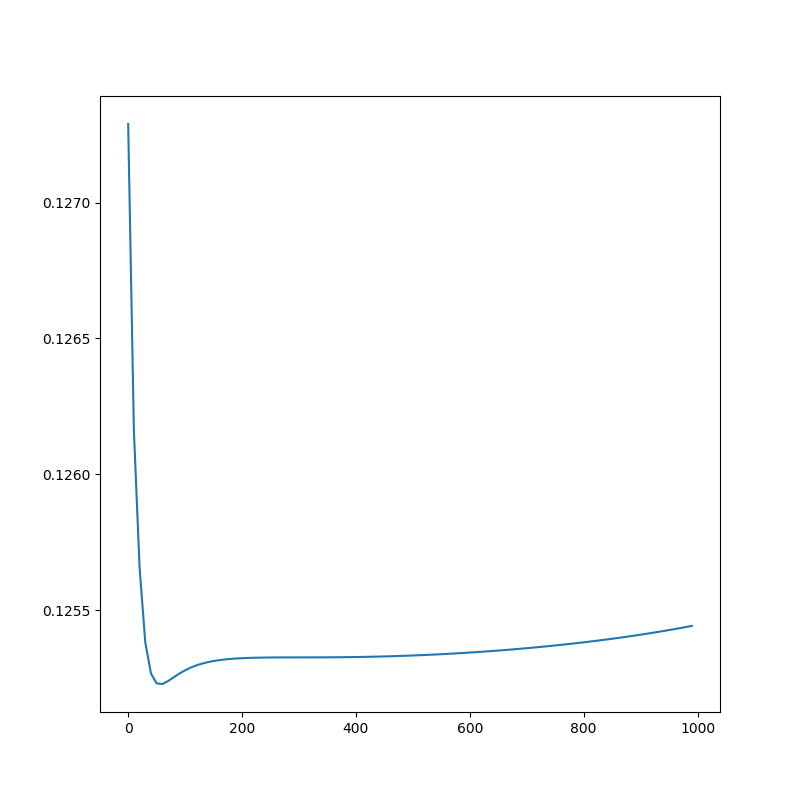

In [14]:
nayves = NayvesNeuronalNetwork()

el, ll = nayves.train(X, y)

plt.figure(figsize=(8,8))
plt.plot(
    el,
    ll
)
plt.show()

Mit etwas Glück erhalten wir nachvollziehbare Werte für eigene Beispiele:

In [15]:
for test in np.array([
    [10., 2.], # change me 😀
    [120, 20],
    [7, 3],    
]):
    print(test)
    print("\t", nayves.feedforward(test))

[10.  2.]
	 0.4983813788893125
[120.  20.]
	 0.4987341993116534
[7. 3.]
	 0.4972590277631105


# Was können wir nicht (mehr) verstehen? 🤔

* Wir können ein Ergebnis für einen Datensatz mittels Feedforward ermitteln.
* Feedforward ist einfach nur eine Hintereinanderausführung von relativ einfachen Rechenschritten.
* Wir können die aktuellen Gewichte/Biase auslesen und diese Berechnungen selbst durchführen.
* Daher können wir das Ergebnis an sich nachvollziehen.
* Wir können allerdings nicht (wirklich) nachvollziehen, wie diese Gewichte/Biase entstanden sind.
* Und unsere Ergebnisse können immer nur so gut wie unsere Daten sein...


# Abschließende Worte

**Macht das wirklich nicht nach! 😂**

* Es gibt genug fertige Bibliotheken.
* Das Beispiel war konstruiert, damit die Demo funktioniert und auch sehr einfach.
* Alle Entscheidungen wurden von mir im Vorfeld getroffen und erprobt, normalerweise wäre das die eigentliche Arbeit.
    * Feature Engineering.
    * Wie viele Layer?
    * Wie viele Neuronen pro Layer?
    * Wie viele Verbindungen?
    * Welche Aktivierungsfunktion(en)?
    * Welche Lossfunktion?
    * Welche Optimierungsart?
    * Welche Hyperparameter (bspw. Learning Rate und Anzahl Epochen)?
    * Verhätnisse zwischen Train, Test & Validate.
    * Under- vs. Overfitting.
* Auch wenn wir eine Programmiersprache verwendet haben, unterscheidet sich die Vorgehensweise vom "normalen" Programmieren.
* Es ist viel mehr "Trail and Error" als "Red Green Refactor".


<p style="font-size:40px;font-weight:bold;text-align:center;">😀Vielen Dank für eure Aufmerksamkeit!😀</p><br/>
